<a href="https://colab.research.google.com/github/HanenEl/Elevvo-Internship/blob/main/Task3%3A%20Customer%20Segmentation%20Using%20RFM%20Analysis/Customer_Segmentation_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read Data
df = pd.read_csv('/content/online_retail_II.csv')

In [52]:
# Show random rows from the dataset
df.sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
25397,491570,84970S,HANGING HEART ZINC T-LIGHT HOLDER,24.0,2009-12-11 12:51:00,0.85,13418.0,United Kingdom,20.40
32160,491983,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,8.0,2009-12-15 09:42:00,2.95,16554.0,United Kingdom,23.60
115,489442,21916,SET 12 RETRO WHITE CHALK STICKS,24.0,2009-12-01 09:46:00,0.42,13635.0,United Kingdom,10.08
38064,492535,48197,DOOR MAT BIRD ON THE WIRE,2.0,2009-12-17 13:09:00,6.75,13577.0,United Kingdom,13.50
23512,491205,90214C,"LETTER ""C"" BLING KEY RING",7.0,2009-12-10 14:07:00,1.25,16779.0,United Kingdom,8.75


In [4]:
# Number of Rows & Coulmns
df.shape

(47114, 8)

In [7]:
# Checking Duplicated Data
df.duplicated().sum()

np.int64(524)

In [ ]:
# Removing Duplicated Data
df = df.drop_duplicates()

In [42]:
# Display Info About Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32543 entries, 0 to 47112
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      32543 non-null  object        
 1   StockCode    32543 non-null  object        
 2   Description  32543 non-null  object        
 3   Quantity     32543 non-null  float64       
 4   InvoiceDate  32543 non-null  datetime64[ns]
 5   Price        32543 non-null  float64       
 6   Customer ID  32543 non-null  float64       
 7   Country      32543 non-null  object        
 8   TotalPrice   32543 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 2.5+ MB


In [48]:
# Display summary statistics
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,32543.0,13.16996,1.0,2.0,4.0,12.0,5184.0,63.835165
InvoiceDate,32543,2009-12-11 13:10:14.563500544,2009-12-01 07:45:00,2009-12-04 14:19:00,2009-12-10 11:51:00,2009-12-15 17:45:00,2010-01-06 14:54:00,NaN
Price,32543.0,3.192713,0.0,1.25,2.1,3.81,1213.02,8.850189
Customer ID,32543.0,15478.408506,12346.0,14087.0,15514.0,16940.0,18286.0,1665.688994
TotalPrice,32543.0,22.320405,0.0,4.95,11.7,19.8,2386.8,62.216077


##Cleanning

In [57]:
# Change the column 'InvoiceDate' from object type to datetime type.
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Change the column 'Customer ID' from Float type to int.
df['Customer ID'] = df['Customer ID'].astype('Int64')

# Remove rows with negative Quantity or UnitPrice
df = df[(df['Quantity'] > 0)]

# Create TotalPrice column for each transaction
df['TotalPrice'] = df['Quantity'] * df['Price']


In [54]:
# Check for missing values
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0
TotalPrice,0


In [53]:
# Remove missing values
df.dropna(subset=['Customer ID', 'Description'], inplace=True)

##RFM Analysis

In [59]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)


In [61]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4,labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 4,labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4,labels=[1,2,3,4])

rfm['RFM_Segment'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)

rfm['RFM_Score'] = (
    rfm[['R_Score','F_Score','M_Score']]
    .astype(int)
    .sum(axis=1)
)

In [69]:
def segment_me(x):
    if x >= 10:
        return 'Loyal'
    elif x >= 8:
        return 'Active'
    elif x >= 6:
        return 'Regular'
    else:
        return 'At Risk'
rfm['Segment'] = rfm['RFM_Score'].apply(segment_me)

In [70]:
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
Customer ID,,,,,,,,,
12346,3,7,158.50,4,4,1,441,9,Active
12358,30,1,1429.83,2,1,4,214,7,Regular
12359,21,2,838.89,4,3,4,434,11,Loyal
12362,37,1,130.00,1,1,1,111,3,At Risk
12417,28,2,317.60,2,3,2,232,7,Regular


##Visualization

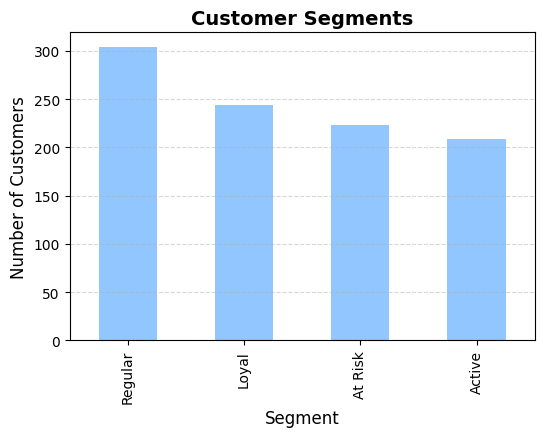

In [76]:
# Customer Segments by bar Plot
rfm['Segment'].value_counts().plot(kind='bar', figsize=(6,4))

plt.title("Customer Segments", fontsize=14, fontweight='bold')
plt.xlabel("Segment",fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

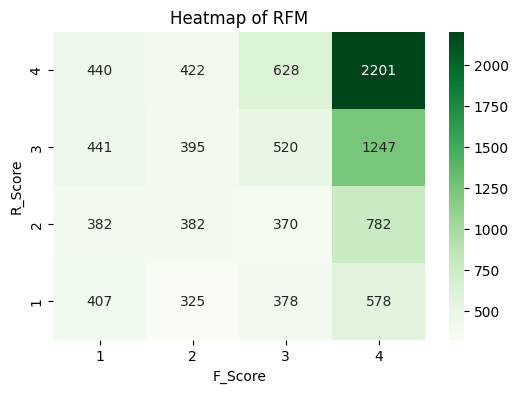

In [84]:
# Customer Segments by heatmap
rfm_pivot = rfm.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='mean')

plt.figure(figsize=(6,4))
sns.heatmap(rfm_pivot, annot=True, fmt=".0f", cmap="Greens")
plt.title("Heatmap of RFM")
plt.show()